# Optimization Methods

梯度下降。

优化方法。

1. Mini-Batch
2. Momentum，动量方法
3. Adam

这里不再用自己的架构写一遍了，主要原因是不太适用了。

理想的结构，应该像tensorflow那样。 主要参数都是 Variable。 可以通过定义优化方法，累积动量或者自适应学习率这种方式学习、更新参数。

这里用tensorflow实现操作。

遇到的问题是，如何保存session？图与session的关系是什么？  keras是如何做到这一点的？

结论是： Adam优化的速度更快。 普通Gradient Descent优化速度较慢；  Momentum也还可以。


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets
import tensorflow as tf

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## 1 - Gradient Descent


在使用 Gradient Descent 和 Stochastic Gradient Descent 时需要注意的区别是：

1. 如果使用GD，就是一次用所有训练样本计算损失函数对参数的梯度，那么此梯度一定是沿着下降最快的方向。
2. 如果使用SGD，一次只用一个样本计算损失函数对参数的梯度，这个梯度就不一定是沿着下降最快的方向。
3. 实际应用中多用MiniBatch。 并且有一些策略优化学习率，以及调整梯度方向（动量）

<img src="images/kiank_sgd.png" style="width:750px;height:250px;">
<caption><center> <u> <font color='purple'> **Figure 1** </u><font color='purple'>  : **SGD vs GD**<br> "+" denotes a minimum of the cost. SGD leads to many oscillations to reach convergence. But each step is a lot faster to compute for SGD than for GD, as it uses only one training example (vs. the whole batch for GD). </center></caption>


<img src="images/kiank_minibatch.png" style="width:750px;height:250px;">
<caption><center> <u> <font color='purple'> **Figure 2** </u>: <font color='purple'>  **SGD vs Mini-Batch GD**<br> "+" denotes a minimum of the cost. Using mini-batches in your optimization algorithm often leads to faster optimization. </center></caption>

<font color='blue'>
**What you should remember**:
- The difference between gradient descent, mini-batch gradient descent and stochastic gradient descent is the number of examples you use to perform one update step.
- You have to tune a learning rate hyperparameter $\alpha$.
- With a well-turned mini-batch size, usually it outperforms either gradient descent or stochastic gradient descent (particularly when the training set is large).

(2, 300)


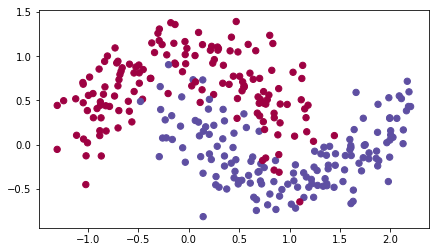

In [22]:
def load_dataset():
    np.random.seed(3)
    train_X, train_Y = sklearn.datasets.make_moons(n_samples=300, noise=.2) #300 #0.2 
    # Visualize the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    
    return train_X, train_Y

train_X, train_Y = load_dataset()
print(train_X.shape)

In [53]:
from tensorflow.python.framework import ops
ops.reset_default_graph() 

# relu -> relu -> sigmoid
n_x, m = train_X.shape
n_1 = 5
n_2 = 2
n_y = 1

X = tf.placeholder(tf.float32, shape=(n_x, None))
Y = tf.placeholder(tf.float32, shape=(n_y, None))

# layer1, relu
W1 = tf.Variable(tf.random_normal((n_1, n_x)))
b1 = tf.Variable(tf.zeros((n_1, 1)))
A1 = tf.nn.relu(tf.matmul(W1, X) + b1)

# layer2, relu
W2 = tf.Variable(tf.random_normal((n_2, n_1)))
b2 = tf.Variable(tf.zeros((n_2, 1)))
A2 = tf.nn.relu(tf.matmul(W2, A1) + b2)

# layer3, sigmoid
W3 = tf.Variable(tf.random_normal((n_y, n_2)))
b3 = tf.Variable(tf.zeros((n_y, 1)))
Z3 = tf.matmul(W3, A2) + b3

# loss
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=Z3))

A3 = tf.sigmoid(Z3)

In [77]:

def train_model(session, train_X, train_Y, num_epochs, minibatch_size):
    costs = []
    m = train_X.shape[1]
    for epoch in range(num_epochs):
        epoch_cost = 0.
        perm = np.random.permutation(m)
        for i in range(0, m, minibatch_size):
            idx = perm[i:i+minibatch_size]
            batch_x = train_X[:, idx]
            batch_y = train_Y[:, idx]
            _ , cost = session.run([optimizer, loss], 
                                     feed_dict={X: batch_x, Y: batch_y})
            epoch_cost += cost * len(idx) / m

        # Print the cost every epoch
        if epoch % 100 == 0:
            costs.append(epoch_cost)
        if epoch % 1000 == 0:
            print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
        
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return costs
    
def predict(session, data):
    a3 = session.run(A3, feed_dict={X: data})
    prediction = (a3 > 0.5).astype(int)
    return prediction

def score(session, data, y):
    p = predict(session, data)
    s = np.mean((p[0,:] == y[0,:]))
    print("Accuracy: "  + str(s))
    return s

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()


Cost after epoch 0: 0.618549
Cost after epoch 1000: 0.170122
Cost after epoch 2000: 0.138634
Cost after epoch 3000: 0.131131
Cost after epoch 4000: 0.127797
Cost after epoch 5000: 0.125395
Cost after epoch 6000: 0.123939
Cost after epoch 7000: 0.122736


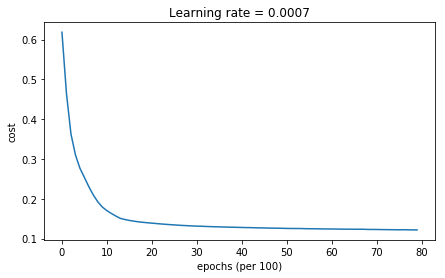

Accuracy: 0.946666666667


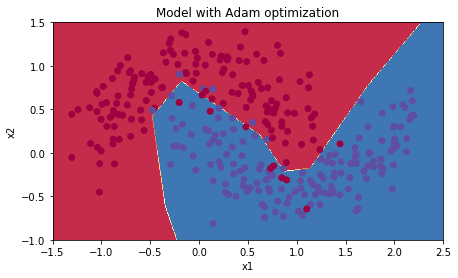

In [78]:
learning_rate =  0.0007
num_epochs = 8000
minibatch_size = 64

# optimizer
# beta1 = 0.9, beta2 = 0.999
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# Initialize all the variables
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init) 

costs = train_model(sess, train_X, train_Y, num_epochs, minibatch_size)

# score
score(sess, train_X, train_Y)

# # Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict(sess, x.T), train_X, train_Y)

sess.close()

Cost after epoch 0: 0.677367
Cost after epoch 1000: 0.534089
Cost after epoch 2000: 0.431231
Cost after epoch 3000: 0.390151
Cost after epoch 4000: 0.363068
Cost after epoch 5000: 0.346119
Cost after epoch 6000: 0.336985
Cost after epoch 7000: 0.329956


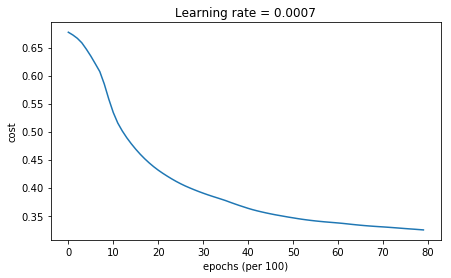

Accuracy: 0.883333333333


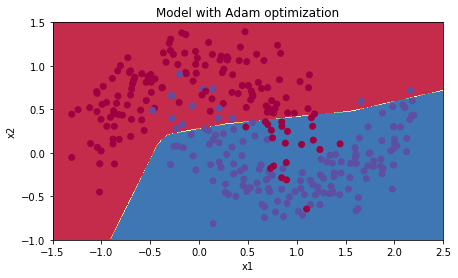

In [80]:
learning_rate =  0.0007
num_epochs = 10000
minibatch_size = 64

# optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

# Initialize all the variables
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init) 

costs = train_model(sess, train_X, train_Y, num_epochs, minibatch_size)

# score
score(sess, train_X, train_Y)

# # Plot decision boundary
plt.title("Model with GD optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict(sess, x.T), train_X, train_Y)

sess.close()

### 5.2 - Mini-batch gradient descent with momentum

Run the following code to see how the model does with momentum. Because this example is relatively simple, the gains from using momemtum are small; but for more complex problems you might see bigger gains.

Cost after epoch 0: 0.722145
Cost after epoch 1000: 0.314694
Cost after epoch 2000: 0.184280
Cost after epoch 3000: 0.155135
Cost after epoch 4000: 0.145268
Cost after epoch 5000: 0.139586
Cost after epoch 6000: 0.135756
Cost after epoch 7000: 0.133218
Cost after epoch 8000: 0.131688
Cost after epoch 9000: 0.130682


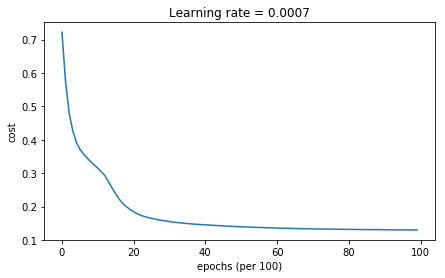

Accuracy: 0.94


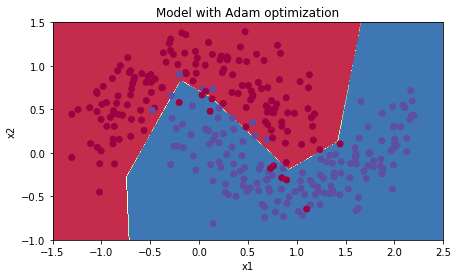

In [82]:
learning_rate =  0.0007
num_epochs = 10000
minibatch_size = 64

# optimizer
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9).minimize(loss)

# Initialize all the variables
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init) 

costs = train_model(sess, train_X, train_Y, num_epochs, minibatch_size)

# score
score(sess, train_X, train_Y)

# # Plot decision boundary
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict(sess, x.T), train_X, train_Y)

sess.close()

### 5.4 - Summary

<table> 
    <tr>
        <td>
        **optimization method**
        </td>
        <td>
        **accuracy**
        </td>
        <td>
        **cost shape**
        </td>

    </tr>
        <td>
        Gradient descent
        </td>
        <td>
        79.7%
        </td>
        <td>
        oscillations
        </td>
    <tr>
        <td>
        Momentum
        </td>
        <td>
        79.7%
        </td>
        <td>
        oscillations
        </td>
    </tr>
    <tr>
        <td>
        Adam
        </td>
        <td>
        94%
        </td>
        <td>
        smoother
        </td>
    </tr>
</table> 

Momentum usually helps, but given the small learning rate and the simplistic dataset, its impact is almost negligeable. Also, the huge oscillations you see in the cost come from the fact that some minibatches are more difficult thans others for the optimization algorithm.

Adam on the other hand, clearly outperforms mini-batch gradient descent and Momentum. If you run the model for more epochs on this simple dataset, all three methods will lead to very good results. However, you've seen that Adam converges a lot faster.

Some advantages of Adam include:
- Relatively low memory requirements (though higher than gradient descent and gradient descent with momentum) 
- Usually works well even with little tuning of hyperparameters (except $\alpha$)

**References**:

- Adam paper: https://arxiv.org/pdf/1412.6980.pdf